## Purpos
This code used Keras LSTM to predict the stock price. The model is one-to-one RNN, and by appending the predicted result to try to predict the stock price of next 90 day. But it seems failed.

In [216]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler


In [217]:
stock= pd.read_csv('stock.csv', parse_dates=True, index_col=0)

In [218]:
print(stock.columns)
print(stock.head())


Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
                Open      High       Low     Close        Volume
Date                                                            
2018-08-22  10790.24  10828.21  10774.69  10804.20           NaN
2018-08-21  10697.01  10792.20  10697.01  10792.20  1.995001e+09
2018-08-20  10698.76  10729.90  10663.44  10699.05  2.087036e+09
2018-08-17  10702.60  10757.01  10688.55  10690.96  2.096415e+09
2018-08-16  10663.57  10725.71  10606.26  10683.90  2.388831e+09


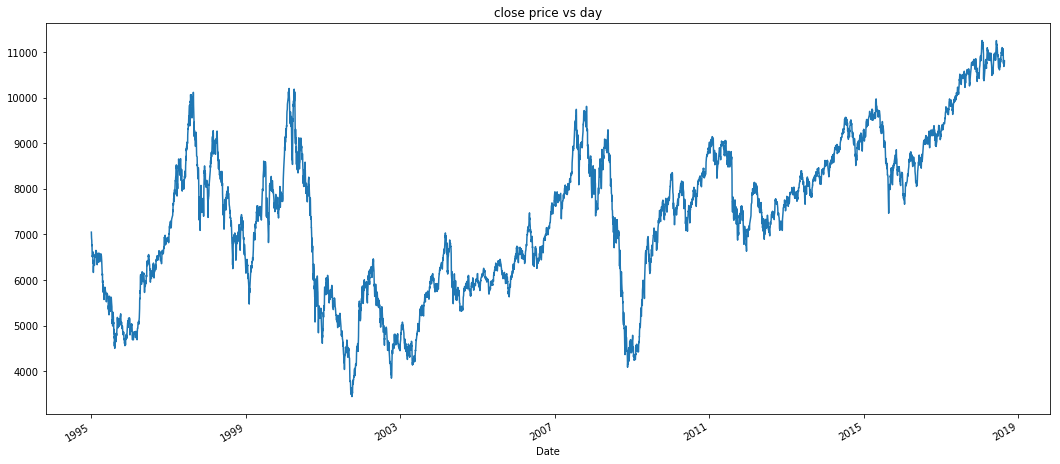

In [219]:
stock.loc[:]['Close'].plot(figsize=(18, 8), title='close price vs day')

                Open      High       Low     Close        Volume
Date                                                            
2018-08-22  10790.24  10828.21  10774.69  10804.20           NaN
2018-08-21  10697.01  10792.20  10697.01  10792.20  1.995001e+09
2018-08-20  10698.76  10729.90  10663.44  10699.05  2.087036e+09
2018-08-17  10702.60  10757.01  10688.55  10690.96  2.096415e+09
2018-08-16  10663.57  10725.71  10606.26  10683.90  2.388831e+09
               Open     High      Low    Close  Volume
Date                                                  
1995-01-05  7129.94  7144.70  7040.72  7051.49     NaN
1995-01-06  7086.88  7086.88  6884.61  6919.31     NaN
1995-01-07  6948.27  6948.27  6855.55  6915.40     NaN
1995-01-09  6948.73  6959.74  6869.08  6869.08     NaN
1995-01-10  6817.85  6838.95  6706.67  6756.88     NaN


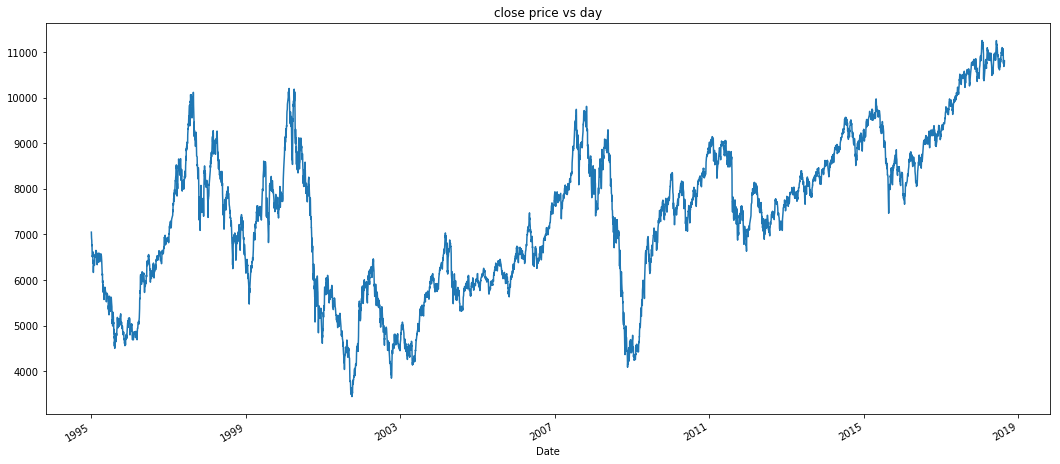

In [220]:
#stock = stock.set_index('Date')
print(stock.head())
stock = stock.sort_index(ascending=True, axis=0)
stock.loc[:]['Close'].plot(figsize=(18, 8), title='close price vs day')
print(stock.head())

In [221]:
print(stock)

                Open      High       Low     Close        Volume
Date                                                            
1995-01-05   7129.94   7144.70   7040.72   7051.49           NaN
1995-01-06   7086.88   7086.88   6884.61   6919.31           NaN
1995-01-07   6948.27   6948.27   6855.55   6915.40           NaN
1995-01-09   6948.73   6959.74   6869.08   6869.08           NaN
1995-01-10   6817.85   6838.95   6706.67   6756.88           NaN
1995-01-11   6736.11   6791.05   6720.07   6777.24           NaN
1995-01-12   6749.62   6749.62   6571.93   6609.50           NaN
1995-01-13   6673.26   6685.93   6582.05   6582.40           NaN
1995-01-14   6565.52   6565.52   6450.79   6511.30           NaN
1995-01-16   6556.98   6556.98   6473.06   6536.65           NaN
1995-01-17   6564.25   6574.77   6487.73   6515.79           NaN
1995-01-18   6558.74   6638.41   6546.99   6623.52           NaN
1995-01-19   6635.62   6672.63   6598.02   6598.02           NaN
1995-01-20   6572.85   65

In [222]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        Y.append(data[(i+lb)])
    return np.array(X),np.array(Y)

In [223]:
window_size = 1

In [224]:
#print(stock['Close'])
#print(stock['Close'].values)
scl = MinMaxScaler(feature_range =(1, 5))
#Scale the data
closes = stock['Close'].values
closes = closes.reshape(closes.shape[0],1)
closes = scl.fit_transform(closes)
print(closes)
X,y = processData(closes, window_size)

[[2.84721366]
 [2.77948853]
 [2.77748516]
 ...
 [4.71611598]
 [4.76384329]
 [4.76999174]]


In [225]:
print(X[1])
print(y[1])

[[2.77948853]]
[2.77748516]


In [226]:
print(stock.loc[stock.index[89], 'Close'])
print(stock.loc[stock.index[90], 'Close'])
print(stock.loc[stock.index[91], 'Close'])

5771.81
5779.68
5699.14


In [227]:
print(len(stock))
print(len(X))
stock_split_index = len(X) - 90
print(stock_split_index)
X_train,X_test = X[:stock_split_index],X[stock_split_index:]
y_train,y_test = y[:stock_split_index],y[stock_split_index:]

5921
5919
5829


In [228]:
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])
print(X_train.shape[1])

5829
90
5829
90
1


In [229]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

In [230]:
config_epochs = 80
#Build the model
model = Sequential()
model.add(LSTM(512,input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
#history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[plot])
history = model.fit(X_train,y_train,epochs=config_epochs,validation_data=(X_test,y_test),shuffle=False)

Train on 5829 samples, validate on 90 samples
Epoch 1/80
5829/5829 [==============================] - 11s 2ms/step - loss: 0.8451 - val_loss: 0.0020
Epoch 2/80
5829/5829 [==============================] - 6s 1ms/step - loss: 0.0130 - val_loss: 0.0018
Epoch 3/80
5829/5829 [==============================] - 6s 1ms/step - loss: 0.0083 - val_loss: 0.0021
Epoch 4/80
5829/5829 [==============================] - 6s 1ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 5/80
5829/5829 [==============================] - 6s 1ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 6/80
5829/5829 [==============================] - 6s 1ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 7/80
5829/5829 [==============================] - 6s 982us/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/80
5829/5829 [==============================] - 6s 1ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 9/80
5829/5829 [==============================] - 6s 1ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 10/80
5829/5829 [==========

Epoch 80/80
5829/5829 [==============================] - 8s 1ms/step - loss: 0.0082 - val_loss: 0.0028


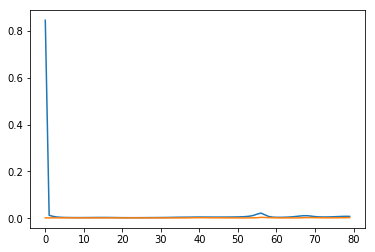

In [231]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

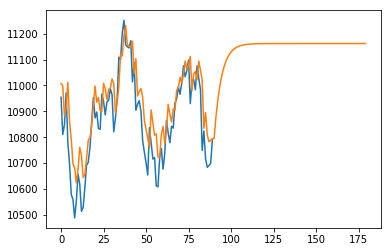

In [232]:
#Xt = model.predict(X_test)
#plt.plot(y_test.reshape(-1,1))
#plt.plot(Xt)
X_test_tmp = X_test.copy()
Xt = model.predict(X_test)

for i in range(90):
    newVal = model.predict(X_test_tmp.reshape(X_test_tmp.shape[0],1,1))
    X_test_tmp = np.append(X_test_tmp, newVal[-1])
    Xt = np.append(Xt, newVal[-1])

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
#plt.plot(stock['Close'].values.reshape(-1,1))
plt.plot(scl.inverse_transform(Xt.reshape(-1, 1)))

In [233]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(window_size,1)))
model.add(LSTM(512,input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
#history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[plot])
history = model.fit(X_train,y_train,epochs=config_epochs,validation_data=(X_test,y_test),shuffle=False)

Train on 5829 samples, validate on 90 samples
Epoch 1/80
5829/5829 [==============================] - 35s 6ms/step - loss: 0.2407 - val_loss: 0.0017
Epoch 2/80
5829/5829 [==============================] - 21s 4ms/step - loss: 0.0228 - val_loss: 0.0037
Epoch 3/80
5829/5829 [==============================] - 22s 4ms/step - loss: 0.0294 - val_loss: 0.0046
Epoch 4/80
5829/5829 [==============================] - 22s 4ms/step - loss: 0.0401 - val_loss: 0.0024
Epoch 5/80
5829/5829 [==============================] - 22s 4ms/step - loss: 0.0926 - val_loss: 0.0046
Epoch 6/80
5829/5829 [==============================] - 22s 4ms/step - loss: 0.2533 - val_loss: 0.2115
Epoch 7/80
5829/5829 [==============================] - 21s 4ms/step - loss: 0.1641 - val_loss: 0.0915
Epoch 8/80
5829/5829 [==============================] - 22s 4ms/step - loss: 0.0455 - val_loss: 0.0329
Epoch 9/80
5829/5829 [==============================] - 23s 4ms/step - loss: 0.0161 - val_loss: 0.0184
Epoch 10/80
5829/5829 [====

5829/5829 [==============================] - 17s 3ms/step - loss: 0.0093 - val_loss: 0.0042
Epoch 80/80
5829/5829 [==============================] - 18s 3ms/step - loss: 0.0081 - val_loss: 0.0038


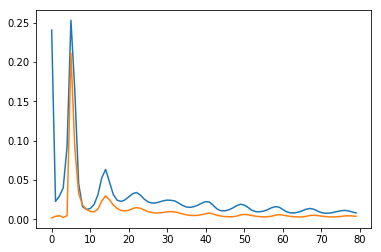

In [234]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

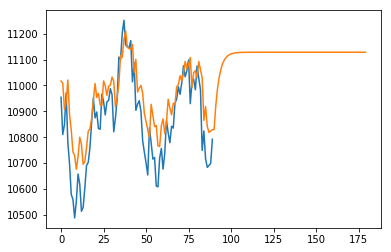

In [235]:
#Xt = model.predict(X_test)
#plt.plot(y_test.reshape(-1,1))
#plt.plot(Xt)
X_test_tmp = X_test.copy()
Xt = model.predict(X_test)

for i in range(90):
    newVal = model.predict(X_test_tmp.reshape(X_test_tmp.shape[0],1,1))
    X_test_tmp = np.append(X_test_tmp, newVal[-1])
    Xt = np.append(Xt, newVal[-1])

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
#plt.plot(stock['Close'].values.reshape(-1,1))
plt.plot(scl.inverse_transform(Xt.reshape(-1, 1)))

In [236]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(window_size,1)))
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(512,input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
#history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False,callbacks=[plot])
history = model.fit(X_train,y_train,epochs=config_epochs,validation_data=(X_test,y_test),shuffle=False)

Train on 5829 samples, validate on 90 samples
Epoch 1/80
5829/5829 [==============================] - 32s 6ms/step - loss: 0.2529 - val_loss: 0.0033
Epoch 2/80
5829/5829 [==============================] - 26s 5ms/step - loss: 0.0703 - val_loss: 0.0093
Epoch 3/80
5829/5829 [==============================] - 26s 5ms/step - loss: 0.3366 - val_loss: 0.3243
Epoch 4/80
5829/5829 [==============================] - 26s 5ms/step - loss: 0.6221 - val_loss: 0.0205
Epoch 5/80
5829/5829 [==============================] - 27s 5ms/step - loss: 0.3697 - val_loss: 0.0071
Epoch 6/80
5829/5829 [==============================] - 27s 5ms/step - loss: 0.1255 - val_loss: 0.0597
Epoch 7/80
5829/5829 [==============================] - 27s 5ms/step - loss: 0.0257 - val_loss: 0.0261
Epoch 8/80
5829/5829 [==============================] - 27s 5ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 9/80
5829/5829 [==============================] - 26s 4ms/step - loss: 0.0148 - val_loss: 0.0087
Epoch 10/80
5829/5829 [====

5829/5829 [==============================] - 36s 6ms/step - loss: 0.0127 - val_loss: 0.0099
Epoch 80/80
5829/5829 [==============================] - 35s 6ms/step - loss: 0.0119 - val_loss: 0.0104


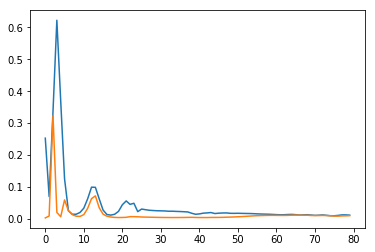

In [237]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

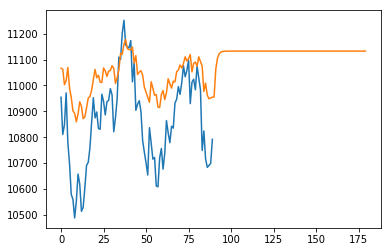

In [238]:
#Xt = model.predict(X_test)
#plt.plot(y_test.reshape(-1,1))
#plt.plot(Xt)
X_test_tmp = X_test.copy()
Xt = model.predict(X_test)

for i in range(90):
    newVal = model.predict(X_test_tmp.reshape(X_test_tmp.shape[0],1,1))
    X_test_tmp = np.append(X_test_tmp, newVal[-1])
    Xt = np.append(Xt, newVal[-1])

plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
#plt.plot(stock['Close'].values.reshape(-1,1))
plt.plot(scl.inverse_transform(Xt.reshape(-1, 1)))